# Preparing the data and query store

In [1]:
import sys
sys.path.insert(0, '../../')

# import rdf_data_citation

from src.rdf_data_citation.citation_utils import CitationData
import src.rdf_data_citation.rdf_star
from src.rdf_data_citation.rdf_star import TripleStoreEngine, prefixes_to_sparql
from src.rdf_data_citation.citation_utils import QueryData, RDFDataSetData, CitationData
from src.rdf_data_citation.citation_utils import generate_citation_snippet, _intersection, _citation_timestamp_format, attach_prefixes
import src.rdf_data_citation.query_store as qs
# import queries_for_testing as q

from datetime import datetime, timedelta, timezone
import pandas as pd
from rdflib.term import Variable
from IPython.display import Image

## R1 - Data Versioning

Coming from relational databases a triple store can be imagined as a table with three fields - subject, predicate, object. if one were about to annotate a triple with a timestamp or other label the fact that no additional “column” can be used within a triple store but only additional rows would make it hard to reference a specific triple. All that could be done is to insert another triple to somehow reference the target triple. However, where would this new triple point at or what would be the subject? Figure 1 illustrates this problem


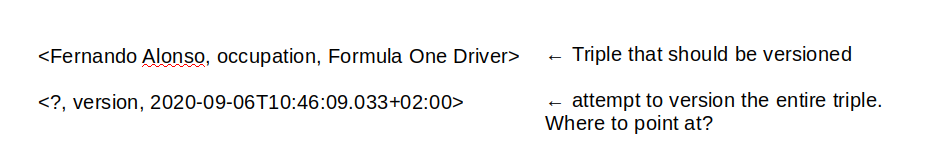

In [2]:
Image(filename='figures/figure 1.png')

One can easily see the problem that the placeholder ? can only take one piece of information (subject or object) of the target triple which does not suffice to reference the triple as a whole. However, if one were able to nest a whole triple within the subject of another it would endow us with the right tool to address data versioning within triple stores. In fact, RDF* and SPARQL* as extensions of RDF and SPARQL respectively are capable of doing exactly this. Figure 2 illustrates the solution for the example brought in figure 1 in actual RDF* syntax.


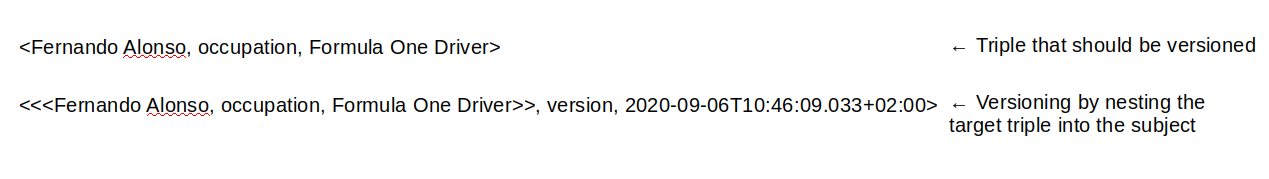

In [3]:
Image(filename='figures/figure 2.png')

This capability of nesting triples is only part of the solution. However, now we can use existing methods that also can be used within relational databases. One way is to use a start and an end date for each triple. As an initial operation all triples should be annotated with the current timestamp as the start date and an end date that is far in the future, e.g. 9999-12-31T00:00.000. From here we have to distinguish between insert, update and delete operations. Finally, to retrieve data as it existed at a certain point in time we would use simple filter operations on the start date and end date attributes. 


### Insert

Whenever a new triple is inserted two additional triples will be inserted - one marking the start date (e.g. current timestamp) of that triple and one setting the end date to 9999-12-31T00:00.000 to mark it as valid until further notice. 


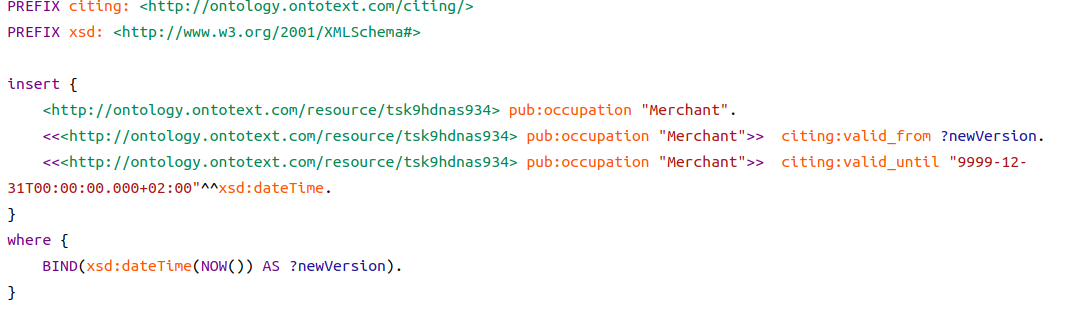

In [4]:
Image(filename='figures/figure 3.png')

### Update

The update operation is a combination of a delete operation followed by an insert. We first must make clear what is actually updated. Here it again helps to think in terms of relational databases. The subject can be seen as a table, the predicate as an attribute of that table and the object as a particular value of that attribute. As we are updating data it goes without saying that we want to perform these operations on the object (the value) of the triple. Therefore, we first perform a delete on the end date of the target triple. Subsequently, we want to give a new end date to the target triple and this could be the current timestamp as this operation is performed. So far, we have only outdated the old value. What is now left to do is to basically perform the same operation as in Insert chapter. 

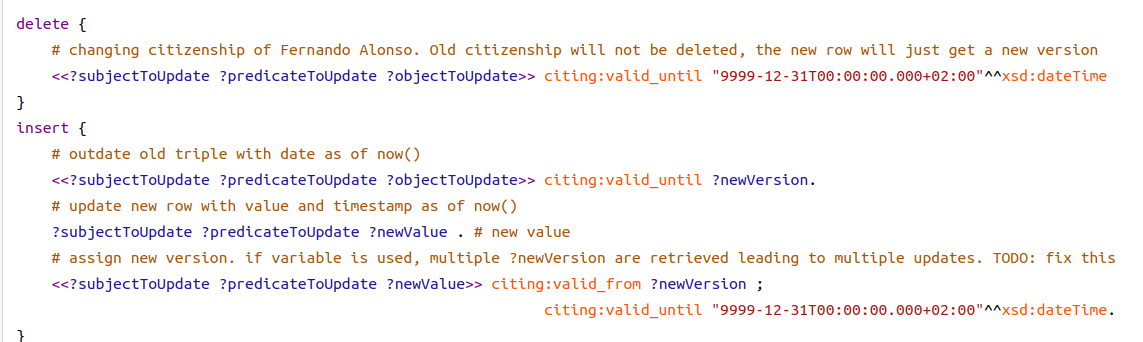

In [5]:
Image(filename='figures/figure 4.png')

### Delete

The idea for the delete operation has already been conceived in the first part of the update operation. Firstly, the target triple’s end date is deleted and secondly the target triple is provided with a new end date, e.g. as of operation date. 


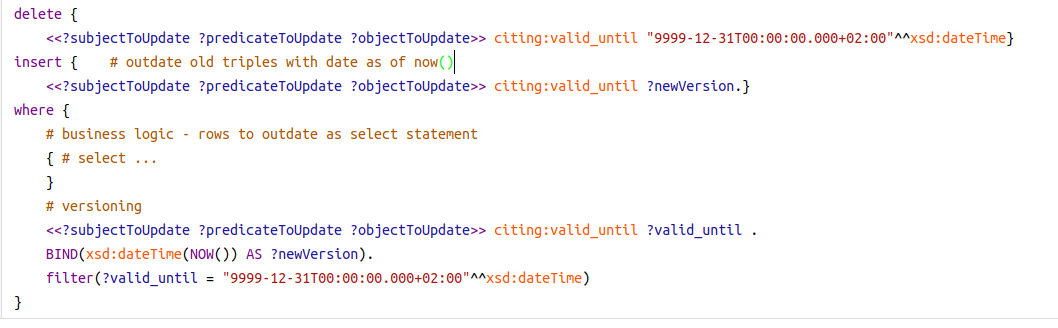

In [6]:
Image(filename='figures/figure 7.png')

### Proof of concept
Following example shall demonstrate that with the above discussed solution it is possible to retrieve earlier states of the data. 

In [7]:
# TU
# http://128.131.200.241:7200/repositories/DataCitation
# http://128.131.200.241:7200/repositories/DataCitation/statements

# Home Network - PC
# http://192.168.0.241:7200/repositories/DataCitation
# http://192.168.0.241:7200/repositories/DataCitation/statements

# Home Network - laptop
# http://192.168.0.25:7200/repositories/DataCitation
# http://192.168.0.25:7200/repositories/DataCitation/statements

# set up endpoints and prepare RDF store for demonstration
rdf_engine = TripleStoreEngine('http://192.168.0.25:7200/repositories/DataCitation', #GET
                               'http://192.168.0.25:7200/repositories/DataCitation/statements') #POST


PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

select * where {
    <<?s ?p ?o>> citing:valid_from ?valid_from_date.
    <<?s ?p ?o>> citing:valid_until ?valid_until_date.
}
Connection to RDF query and update endpoints http://192.168.0.25:7200/repositories/DataCitation and http://192.168.0.25:7200/repositories/DataCitation/statements established


In [ ]:
vieTZObject = timezone(timedelta(hours=2))
initial_timestamp = datetime(2020, 9, 1, 12, 11, 21, 941000, vieTZObject)
rdf_engine.version_all_rows(initial_timestamp)

During the timestamping two additional prefixes will be added, namely  
PREFIX citing: <http://ontology.ontotext.com/citing/> and PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>. Below is an example query we will use throughout this notebook. It also has a subquery with a different variable set in the select clause than the outer one. This way, we will test whether the the right variable set will be selected for the result set.

In [ ]:
# Prepare test query and timestamps
original_query = """
PREFIX pub: <http://ontology.ontotext.com/taxonomy/>
PREFIX publishing: <http://ontology.ontotext.com/publishing#>

select ?personLabel ?party_label ?document ?mention {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?party_label .
    
    filter(?personLabel = "Barack Obama"@en)
} order by ?document ?mention
"""
rdf_engine.get_data(original_query) # dataframe

Let's make Obama a Rebublican now...

In [ ]:
triples_to_update = """
PREFIX pub: <http://ontology.ontotext.com/taxonomy/>
PREFIX publishing: <http://ontology.ontotext.com/publishing#>

select ?subjectToUpdate ?predicateToUpdate ?objectToUpdate {
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?party_label .
    filter(?personLabel = "Barack Obama"@en) 
    
    bind(?person as ?subjectToUpdate)
    bind(pub:memberOfPoliticalParty as ?predicateToUpdate)
    bind(?party as ?objectToUpdate)
} 
"""
new_value = "<http://ontology.ontotext.com/resource/Q201795S476DFED9-C64A-4E56-B4C3-CFB368801FBF>"
rdf_engine.update(triples_to_update, new_value)

In [ ]:
queryUtils = QueryData(original_query)
timestamp1 = datetime.now(vieTZObject)
timestamped_query_1 = queryUtils.timestamp_query(citation_timestamp=timestamp1)
rdf_engine.get_data(timestamped_query_1) # dataframe

Let us now assume that a new mention of Obama is found within a document and gets added to the tripple store. If we take the initial timestamp again and execute the query we see that the result has not changed, which is what we expected. However, the query with the most recent timestamp (sysdate) will return the dataset where the newly added triples are visible.

In [ ]:
prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'publishing': 'http://ontology.ontotext.com/publishing#'}

mention = "<hhttp://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>"
hasInstance = "publishing:hasInstance"
person = "<http://ontology.ontotext.com/resource/tsk4wye1ftog>"

rdf_engine.insert_triple((mention, hasInstance, person), prefixes)

document = "<http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010>"
containsMention = "publishing:containsMention"
mention = "<hhttp://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>"

rdf_engine.insert_triple((document, containsMention, mention), prefixes)

In [ ]:
# Newly added triples
timestamp2 = datetime.now(vieTZObject)
timestamped_query_2 = queryUtils.timestamp_query(citation_timestamp=timestamp2)
rdf_engine.get_data(timestamped_query_2)

In [ ]:
original_query_timestamped = queryUtils.timestamp_query(citation_timestamp=initial_timestamp)
rdf_engine.get_data(original_query_timestamped) # dataframe

Finally, we make sure to delete all the added triples in order for the experiment to be repeatable.

In [ ]:
# Clean up
rdf_engine._delete_triples((mention, hasInstance, person), prefixes)
rdf_engine._delete_triples((document, containsMention, mention), prefixes)

prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'xsd': 'http://www.w3.org/2001/XMLSchema#',
            'publishing': 'http://ontology.ontotext.com/publishing#'}
person = "<http://ontology.ontotext.com/resource/tsk4wye1ftog>"
memberOfPoliticalParty = "pub:memberOfPoliticalParty"
party = "<http://ontology.ontotext.com/resource/Q201795S476DFED9-C64A-4E56-B4C3-CFB368801FBF>"
rdf_engine._delete_triples((person, memberOfPoliticalParty, party), prefixes)

rdf_engine.reset_all_versions()

## R2 - Timestamping 

Operations on data should be timestamped. If we look at the suggested solution for R1, we see that timestamps are already applied with every operation. Now, one could use the operation timestamp for both - versioning data and timestamping the operation itself. The proposed solution for R1 would allow retrieving each operation’s timestamp but also a specific version of the dataset (as it was at a specific point in time). The start date annotation tells us also the timestamp of the insert and update operation. If a semantically valid end date (not 9999-12-31T00:00.000) is used to mark triples as outdated it can also be seen as the timestamp of the delete operation. 
However, if one wants to distinguish between a real delete and a delete as part of an update, this approach would lead to ambiguity. Therefore, another proposed solution is to use a further annotation “operation_date” and stamp the operation itself. This solution has the following benefit: A different timestamp than the operation timestamp could be used for versioning data. Some use cases might require to version data with specific timestamps (E.g. end of the day the operation was performed)


## R3 - Query Store Facilities

The query store is a means to store queries and the associated metadata. For the query store it is not important whether the underlying database is a graph database, document-based or relational database. The query itself is just a string of characters in all cases and a simple database like SQLite in combination with Python’s object relational mapper SQL Alchemy is proposed as the Query Store. An examination of query store implementations by EODC, VMC, CCCA, EHR and VAMDC exposed following more common metadata which are proposed to by covered by default by the framework:

In [ ]:
Image(filename='figures/figure 6.png', width=800, height=680)

# Persistently Identify Specific Data Sets

In [ ]:
Image(filename='figures/figure 5.png')

Every time a data set should be persisted the following operations are performed. The algorithm starts of with two parallel and independent streams of operations. Thus, in the implementation it does not matter which one gets executed first. The **left stream** ultimately searches the query store for the provided query. It does so by trying to find a matching query checksum of the normalized query. Therefore, normalization and query checksum compuation comes before the lookup. The **right stream** sets the ground for comparison of the result set checksums once the query has been found in the query store. Before the result set checksum compuation the query must be extended with a timestamp filter and sort operation. 

Next, a few case distinctions are needed. If the **query is found** we compare the result set checksums of the retrieved and provided query. Over time the result set might have changed. That is why we compare the result sets with their respective timestamps so we can see whether changes like number of rows returned or value changes occured. Also the order of rows might differ, if no sort operation is aplied, simply due to the fetching mechanism of the underlying database management system. The sort operation we used before should make the rows of either dataset unambiguos. If the **new query still yields the same result set checksum** then we can simply retrieve and return the already existing citation snippet of the stored query. If either of these two checks are not fullfilled, meaning that the query is truly new, a new query PID gets created followed by a citation snippet. Both information along with other query attributes get encapsulated within a query object and written to the query store.

A user retrieves data via an user interface by either executing a query or using graphical features to build the data set (which, in fact, executes a query in the background). At any point the user can request the citation text by means of graphical features (e.g. button) or terminal commands. Following example shall demonstrate the citation process as illustrated in figure 5.

## Case 1: Query is new

In [ ]:
queryUtils = QueryData(original_query, timestamp1)

print(queryUtils.sparql_prefixes)
print(queryUtils.query)

### R4a - Query uniqueness: Normalize query algebra

| Number | Statement description | Normalization measure   |
|------|------|------|
|1 | WHERE clause is optional | A where clause will always be inserted |
|2 | "rdf:type" predicate can be replaced by "a" | rdf:type will always be replaced by "a" |
|3 | if all variables are selected one does not need to write a variable in the form ?s but can just use an asterisk | Variables will always be explicitely mentioned and ordered alphabetically |
|4 | If the same subject is used multiple times in subsequent triplets separated by a dot it can be simplified by writing just the first subject variable name, separating the triplets by semicolons and leaving out the other variable names that are equal to the one in the first triplet | Triples will never be simplified and simplified triples will be made explicit |
|5 |   The order of triple statements does not affect the outcome | Triple statements will be ordered alphabetically by subject, predicate, object |
|6 | Aliases via BIND keyword just rename variables but the query result stays the same  | Do not know how to tackle yet |
|7 | Variable names in general can differ between two queries without changing the outcome.  | Variables will be replaced by letters from the alphabet. For each variable a letter from the alphabet will be assigned starting with 'a' and in chronological order. Two letters will be used and chronological combinations will be assigned should there be more than 26 variables.  |
|8 | Finding variables that are not bound can be written in two ways: 1. with optional keyword adding the optional triplet combined with filter condition !bound(?var); 2. with "filter not exists (triplet)" | No solution yet |
|9 | Inverting the order of the triplet (object predicate subject instead of subject predicate object) using "^" gives the same results | Inverted triples will be back-inverted and "^" will thereby be removed |
|10 | sequence paths can reduce the number of triplets in the query statement and are commonly used. | Sequence paths will be made explicit in form triple statements |
|11 | Prefixes can be interchanged in the prefix section before the query and subsequently in the query without changing the outcome. | All prefixes will be substituted with their underlying URIs |

Now we apply the normalization step on our example query which covers RDF statements from the table above.

In [ ]:
normalized_query_tree = queryUtils.normalize_query_tree(original_query)
print(normalized_query_tree)

#### Proof of concept

To proof that normalized query objects of semantically identical queries yield the same checksums a bunch of semantically identical queries with respect to aforementioned semantics are prepared. Then the queries are normalized by normalizing their individual "algebra trees" and their checksums are computed. We can see that all checksums are equal, which is the expected result.

In [ ]:
prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'publishing': 'http://ontology.ontotext.com/publishing#'}

#1: WHERE clause is optional
query_1 = """
select ?document ?mention ?party ?person ?personLabel ?value {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?party ?person
"""

#3: if all variables are selected one does not need to write a 
# variable in the form ?s but can just use an asterisk
query_3 = """
select * {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?party ?person
"""

#5: The order of triple statements does not affect the outcome
query_5 = """
select ?document ?mention ?party ?person ?personLabel ?value {
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?party ?person
"""

#7: Variable names in general can differ between two queries without changing the outcome
query_7 = """
select ?mention ?x ?party ?person ?personLabel ?value {
    ?x publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
} order by ?x ?mention ?party ?person
"""


queries = {"query1": query_1, 
           "query3": query_3,
           "query5": query_5, 
           "query7": query_7}

In [ ]:
def query_checksum_workflow(query_without_prefixes: str, query_name: str, prefixes: dict, timestamp: datetime):
    query_string = attach_prefixes(query_without_prefixes, prefixes)
    q_utils = QueryData(query_string, timestamp)
    normalized_query_tree = q_utils.normalize_query_tree(query_string) 
    query_checksum = q_utils.compute_checksum(normalized_query_tree) 
    print("{0}: \t \t checksum {1} ".format(query_name, query_checksum))

for query_name, query_string in queries.items():
    query_checksum_workflow(query_string, query_name, prefixes, timestamp1)

We can see that the checksums are all equal meaning that the normalization behaves as intended and the query algebra is indeed the same for all of the above query syntaxes. Notice that all queries have the same user sort applied. Two queries with distinct user sorts will also yield two distinct query checksums.

### R4b - Query uniqueness: Compute query checksum

The checksum of the normalized query string is computed. However, the query is not timestamped yet. We want first to check whether a normalized query with the same checksum exists. If so, we will only then apply the timestamp and furthermore sort operation. As our query is new at this point the checksum will not be found. We will move on to generate the citation snippet and store the query.

In [ ]:
query_checksum = queryUtils.compute_checksum(normalized_query_tree)
print(query_checksum)

### R7 - Query Timestamping
Extend query with the timestamp as of citing. if the timestamp was already assigned to the query object the function below will use this member variable to the extend the query string. Therefore, no timestamps needs to be passed. If, however, a timestamp is passed, it will be used instead.

In [ ]:
# Parameters are: self.citation_timestamp
timestamped_query = queryUtils.timestamp_query(original_query, timestamp1)

#### Proof of concept

We can see the versioning extensions highlighted. The first one is the citation timestamp in blue. For every triple statement in the query two nested triple statements with the valid_from and valid_until date and a filter to select only the triples as of citation date and time.

In [ ]:
# Just for presentation
timestamped_query_colored = queryUtils.timestamp_query(original_query, timestamp1, colored=True)
print(timestamped_query_colored)

# SPARQL extensions: Functions can be added

### R5 - Stable Sorting

#### Challenge with sorting

The R5 recommendation states that there must be a "unique criterion, which allows creating a total ordering of the records in the data set and the subsets thereof". "Automatically specifying the primary key, followed by a user sort" is proposed as solution. The challenge especially for RDF datasets is that there are no primary keys. It could be up for discussion whether such constraints could be placed in the metamodel or triples could be annotated by the RDF database designer. Let us for now assume the probably more realistic case that each subgraph needs to be thought of as an individual dataset without any constraints on the result columns. Therefore, a unique index that can be used for sorting prior to the user sorts needs to be derived first. 

We tried to tackle this problem with an algorithm that computes the "simplest" possible unique (multi-)index from the dataset. Simple hereby means that each (multi-)index is a minimum set of columns. E.g. only one column could be enough to serve as a unique index for sorting. This unique index does not have to be the natural or business key which the user would define based on the business model. The algorithm starts by iterating through every single column and checking whether it would make up a unique index or not. If no unique index is found it goes on by trying out every column pair combination. If still no unique indexes are found it goes on with triple combinations and so on. Bear in mind that the iteration is deterministic and depends on the column order (see discussion later on). One challenge we face with the index derivation is that there could be more possible solutions derived. E.g. there could be two columns where each has as many distinct values as rows or two possible compositions of columns where each composition would yield an unambiguos order upon every execution when used in the "order by" clause. If such a list of multiple possible multi-indexes is returned by the algorithm a solution would be to always take the first index from that list. This ultimately leads to the discussion whether the column names/aliases and column order should matter in the select clause of the query, thus, whether two queries should be called semantically identical even if they use different column aliases and/or columns are placed in a differing order. Let us start with distinguishing four possible cases where we could call two queries semantically identical.

a = Two queries have the same column aliases in the select clause;
b = Two queries have the same column order in the select clause

* Case 1: a $\wedge$ b: This case is trivial as both queries are syntactically identical. $\newline$

* Case 2: a $\wedge$ $\neg$ b: From a business perspective it could make sense to consider such queries as "one and the same". After the dataset is obtained the column placement could be rearranged anyway just for presentation reasons without hazarding the further processing by any means. Let us now assume that we are given **two** SPARQL queries with different column placements but otherwise identical. The natural or business key for both queries is unknown, as already stated, and we need to make a suggestion on which index to use for sorting. The currently developed algorithm could ensure that for such two queries two identically ordered lists are returned only if a sort is done on the column names.  $\newline$

* Case 3: $\neg$ a $\wedge$ b: It is easy to imagine that in business setting one wants to have a controlled set of domain values to foster understanding of business terms. One business term could have multiple synonyms or abbreviations, e.g. one dataset could have a column name "track" and the other one "song" but they mean the same thing. So it is reasonable that queries with different names could be considered semantically identical. Let us make the same assumptions as in case 2. Our algorithm could ensure that for such queries the same output is produced by normalizing the column names first, meaning that a letter or a number is assigned to each column so that the datasets end up having identical column names. However, this would mean that we are not allowed to sort the columns prior to normalization as the mapping to letters or numbers would differ betweem these two sets. This finally leads to our final "impossible" case.

* Case 4: $\neg$ a $\wedge$ $\neg$ b: If both conditions are not met but the two queries are still considered as semantically identical our algorithm has no chance to produce identically ordered lists of multi-indexes. This raises the question whether we either need to look for another algorithm to determine unqiue indexes for sorting or of we should ask for user input at first place to define a natural key for the dataset he/she is about to cite.


The normalized and timestamped query is now extended with the "order by" operation.

In [ ]:
# Should different column names produce different query checksums?
query_result = rdf_engine.get_data(timestamped_query)
rdf_ds = RDFDataSetData(query_result)
sort_variables = rdf_ds.sort_order
query_for_execution = queryUtils.timestamp_query(original_query, timestamp1, sort_variables)

#### Proof of concept

In [ ]:
# Different evaluation scenarios
print("Test 1: Three equal columns and one different. One row is duplicated therefore it does"\
      "not matter which one comes first. This row gets dropped.") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds1.csv", delimiter=',')
rdf_ds = RDFDataSetData(test_df)
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 2: Multiple possible composite keys. Is user feedback needed here?") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds2.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 3: Column names changed compared to test 2 so that a sort of column " \
      "names would yield a different order for datasets in test 2 and test 3. However, the output compared" \
      " to test 2 does not change. For RDF-data this might be desired as variable names/labels do not matter")
test_df = pd.read_csv("data/test_primary_key_suggestor_ds3.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 4: Like test 3 but different permutation of columns. This, in fact, yields a different order "\
      "of key attributes within each suggested composite key, thus also leading to a differnt sorting. "\
      "If this gets 'fixed' then test 3 fails. Is user input needed here?") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds4.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 5: Like test 4 but all columns are have different number of distinct values now. The composite key(s) "\
      "with the highest sum of 'distinct stacked key attribute values' from the list of potential " \
      "composite keys gets suggested") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds5.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )


In [ ]:
# Test with real data from the new dataset
test_df = pd.read_csv("data/dem_and_rep_party_members_mentions.csv", delimiter=',')
rdf_ds = RDFDataSetData(test_df)
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order)

In [ ]:
# Just for presentation
query_for_execution_colored = queryUtils.timestamp_query(original_query, timestamp1, sort_variables, colored=True)
print(query_for_execution_colored) 

### R6 - Compute Result set checksum

The checksum computation is column order independent but row order dependent. The row order indenpendence is accomplished by taking row vector sums. Trivialy, the order of the summands does not affect the sum. The rows are sorted by a unique index before the checksum is computed. The index is either computed by our algorithm or provided by the user if the algorithm yields ambiguous results.

In [ ]:
query_result = rdf_engine.get_data(timestamped_query)

query_tree_variables = []
for v in queryUtils.variables:
    if isinstance(v, Variable):
        query_tree_variables.append(v.n3()[1:])

dataset_variables = _intersection(query_result.columns, query_tree_variables)
rdf_ds = RDFDataSetData(query_result[dataset_variables])
sorted_ds = rdf_ds.sort()
rdf_ds.dataset = sorted_ds
rdf_ds.checksum = rdf_ds.compute_checksum()

print("Result set checksum: ", rdf_ds.checksum)

#### Proof of concept

In **R4a - Query uniqueness: Normalize query algebra** we defined some queries to proof that they are semantically identical by computing and comparing their checksums. Now we can further support the proof by showing that the result set checksums are also equal. 

In [ ]:
def workflow_result_set_checksum(query_without_prefixes: str, query_name: str, prefixes: dict, timestamp: datetime):
    query_string = attach_prefixes(query_without_prefixes, prefixes)
    queryUtils = QueryData(query_string, timestamp)
    timestamped_query = queryUtils.timestamp_query()
    query_result = rdf_engine.get_data(timestamped_query)
    
    query_tree_variables = []
    for v in queryUtils.variables:
        if isinstance(v, Variable):
            query_tree_variables.append(v.n3()[1:])
    
    dataset_variables = _intersection(query_result.columns, query_tree_variables)
    rdf_ds = RDFDataSetData(query_result[dataset_variables])
    #custom_sort_order = ('mention', )
    # custom_sort_order can be provided as parameter in sort()
    sorted_ds = rdf_ds.sort()
    rdf_ds.dataset = sorted_ds
    rdf_ds.checksum = rdf_ds.compute_checksum()
    
    print("query {0}: \t sort_order: {1} \t result_set_checksum: {2}".format(query_name,
                                                                             rdf_ds.sort_order,
                                                                             rdf_ds.checksum))

for query_name, query_without_prefixes in queries.items():
    workflow_result_set_checksum(query_without_prefixes, query_name, prefixes, timestamp1)

If we take a look at two citations dates that are one day apart and we know that the dataset has not changed between these two dates, we would expect the same result set checksum. As shown below, this is exactly what we get.

In [ ]:
# timestamp1 was already assigned above, just here for reminder
# timestamp1 = datetime(2020, 9, 8, 12, 11, 21, 941000, vieTZObject) 
timestamp4 = datetime(2020, 9, 9, 12, 11, 21, 941000, vieTZObject)

workflow_result_set_checksum(original_query, "original query", {}, timestamp1)
workflow_result_set_checksum(original_query, "original query", {}, timestamp4)


### R10 - Automated Citation texts

To generate the citation snippet some information is needed first. First, we need to generate a query PID which is based on the citation timestamp and the query checksum. This way we will be able to identify queries across a timeframe where multiple citations could occur where the result set changes but the query stays unchanged, latter meaning that the checksum is the same. Second, we need to describe our result set. Unfortunatelly, we do not have means yet to automatically derive a description from the underlying result set. That is why we will manually provide it at this stage of project. Last, we need to collect metadata about the cited dataset, such as author, publisher, resource type, title, edition. These metadata attributes are inspired by existing metadata sets, such as *Dublin core*, *dataverse* and *FORCE11*. At this point, we will pass a manually created metadata set, which would usually be collected from the landing page or environment where the citation framework is employed. Other suggested metadata attributes, such as unique number fingerprint (result set checksum), persistent URI (query checksum) will be generated by the framework.

In [ ]:
# The resource type "Dataset" is taken from the controlled list of values. The value "RDF data" is arbitrary
citation_data = CitationData(identifier="DOI_to_landing_page", creator="Filip Kovacevic",
                             title="Judy Chu occurences", publisher="Filip Kovacevic",
                             publication_year="2021", resource_type="Dataset/RDF data", 
                             other_citation_data={"Contributor": "Tomasz Miksa"})


# Generate citation snippet
queryUtils.generate_query_pid(queryUtils.checksum, timestamp1)
citation_snippet = generate_citation_snippet(queryUtils.pid, citation_data)
citation_data.citation_snippet = citation_snippet
print(citation_snippet)

### R9 - Store query

All that is left to do is to store the query and all the relevant information that can be read from the query object along with the citation snippet. 

In [ ]:
rdf_ds.description = "Result set description: All documents where Judy Chu was mentioned with every mention listed"

# path to database is set in the __init__ method and should not be changed!
query_store = qs.QueryStore() 
query_store.store(queryUtils, rdf_ds, citation_data)

## Case 2: Query exists and result set still the same as last time it was cited

#### Execute Query
The same citation snippet that was generated in Case 1 should get returned.

In [ ]:
existing_query_data, existing_query_rdf_ds_data, existing_query_citation_data = query_store.lookup(queryUtils.checksum)
if existing_query_data:
    if rdf_ds.checksum == existing_query_rdf_ds_data.checksum:
        query_pid = existing_query_data.pid
    else:
        # Case 3
        pass 
    citation_snippet = citation_data.citation_snippet
else:
    # Case 1
    pass 

print(citation_snippet)


## Case 3: Query exists and the result set changed compared to last time it was cited

First, we need to create a new query "query2" where the query string is the same as our example query but the citation timestamp is a more recent one.

In [ ]:
query2 = QueryData(original_query, timestamp2)

# Same query checksums
print("Existing query checksum \t", queryUtils.checksum)
print("'New' query cehcksum \t \t", query2.checksum)

Then we will repeat the procedure as done when citing the query for the first time (normalization, timestamping, sorting, checksum computation).

In [ ]:
normalized_query_tree2 = query2.normalize_query_tree()
query2_checksum = query2.compute_checksum(normalized_query_tree2)
# Timestamp 1 < timestamp 2
timestamped_query2 = query2.timestamp_query(original_query, timestamp2) 
query2_result = rdf_engine.get_data(timestamped_query2)

query2_tree_variables = []
for v in query2.variables:
    if isinstance(v, Variable):
        query2_tree_variables.append(v.n3()[1:])

dataset2_variables = _intersection(query2_result.columns, query2_tree_variables)
rdf_ds2 = RDFDataSetData(query2_result[dataset_variables])
sorted_ds2 = rdf_ds2.sort()
rdf_ds2.dataset = sorted_ds2
rdf_ds2.checksum = rdf_ds2.compute_checksum()

print("Different result set checksums because as of timestamp2 there is one record less in the dataset")
print(rdf_ds.dataset.count(), rdf_ds.checksum)
print(rdf_ds2.dataset.count(), rdf_ds2.checksum)

Last, we need to cover the third case meaning that we will lookup the query and find a match in the query store. We will compare the result set checksums of the existing and new query and realize that the checksums are not matching. Therefore, a new query PID and citation snippet will be generated and stored. From the printed citation snippet we can see that a new query PID had been assigned. To make the experiment repeatable we remove all the records we have inserted so far

In [ ]:
# Citation Data creation
citation_data2 = CitationData(identifier="DOI_to_landing_page", creator="Filip Kovacevic",
                                title= "Judy Chu occurences", publisher="Max Musterman",
                                publication_year="2021", resource_type="Dataset/RDF data", 
                                other_citation_data={"Contributor": "Tomasz Miksa"})

# Algorithm
existing_query2_data, existing_query2_rdf_ds_data, existing_query2_citation_data = query_store.lookup(query2.checksum)
if existing_query2_data:
    print("Query 2 result set checksum: {0}".format(rdf_ds2.checksum))
    print("Existing query result set checksum: {0}".format(existing_query2_rdf_ds_data.checksum))
    print("\n")
    if rdf_ds2.checksum == existing_query2_rdf_ds_data.checksum:
        # Case 2
        pass 
    else:
        query2.generate_query_pid(query2.checksum, timestamp2)
        citation_snippet2 = generate_citation_snippet(query2.pid, citation_data2)
        citation_data2.citation_snippet = citation_snippet2
        query_store.store(query2, rdf_ds2, citation_data2, False)
        # new Query PID
        query_pid2 = query2.pid 
    citation_snippet2 = citation_data2.citation_snippet
else:
    # Case 1
    pass 

print("\nNew citation snippet: ")
print(citation_snippet2)

In order for the experiment to be repeatable every time this notebook is run we need to make sure that records which were previously inserted are removed from the query store.

In [ ]:
query_store._remove(queryUtils.checksum)

# Resolving PIDs and Retrieving the Data

In [ ]:
# Retrieve the data set using the Query PID


